# Protein-Level Analysis Tutorial

This tutorial demonstrates a complete protein-level analysis workflow using ProteoPy, from data loading through differential abundance analysis. We use the Karayel et al. (2020) erythropoiesis dataset, which contains protein quantifications across five cell types during red blood cell maturation.

**Learning objectives:**
- Load and annotate proteomics data using the AnnData framework
- Perform quality control filtering and visualization
- Apply normalization and imputation
- Run differential abundance analysis
- Visualize and interpret results

**Dataset:**
Karayel, Ö., et al. (2020). Integrative proteomics reveals principles of dynamic phosphosignaling networks in human erythropoiesis. *Mol Syst Biol* 16, MSB20209813. [DOI: 10.15252/msb.20209813](https://doi.org/10.15252/msb.20209813)

**Note:** ProteoPy is designed around the AnnData data structure where:
- `.X` contains the intensity matrix (samples × proteins)
- `.obs` stores sample/observation metadata
- `.var` stores protein/variable metadata
- `.uns` stores unstructured data like color schemes

In [1]:
# Jupyter autoreload for development
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

import proteopy as pr  # Convention: import proteopy as pr

random.seed(42)

cwd = Path('.').resolve()
root = cwd.parents[1]
os.chdir(root)

/opt/homebrew/Caskroom/miniforge/base/envs/proteopy1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

ProteoPy provides multiple ways to load data:
- `pr.read.long()` - Load generic long-format tables (sample_id, protein_id, intensity)
- `pr.read.diann()` - Load DIA-NN output directly
- `pr.datasets.*` - Load built-in example datasets

Here we prepare the Karayel 2020 dataset as TSV files to demonstrate `pr.read.long()`.

In [3]:
# Export built-in dataset to TSV files for demonstration
# This creates three files: intensities (long format), sample annotations, and protein annotations
adata = pr.datasets.karayel_2020()

intensities_path = 'data/karayel_2020_intensities.tsv'
sample_annotation_path = 'data/karayel_2020_sample_annotations.tsv'
var_annotation_path = 'data/karayel_2020_protein_annotations.tsv'

# Convert wide matrix to long format (sample_id, protein_id, intensity)
intensities = adata.to_df().reset_index(names='sample_id')
intensities_long = intensities.melt(
    id_vars='sample_id',
    var_name='protein_id',
    value_name='intensity',
    )
intensities_long.to_csv(intensities_path, sep='\t')

adata.obs.to_csv(sample_annotation_path, sep='\t', index=False)
adata.var.to_csv(var_annotation_path, sep='\t', index=False)

del adata

The long-format intensities file contains one row per measurement (sample × protein):

In [4]:
!head -n5 {intensities_path}

	sample_id	protein_id	intensity
0	LBaso_rep1	A0A024QZ33;Q9H0G5	15084.2626953125
1	LBaso_rep2	A0A024QZ33;Q9H0G5	15442.2646484375
2	LBaso_rep3	A0A024QZ33;Q9H0G5	13992.021484375
3	LBaso_rep4	A0A024QZ33;Q9H0G5	18426.5390625


In [5]:
!head -n5 {sample_annotation_path}

sample_id	cell_type	replicate
LBaso_rep1	LBaso	rep1
LBaso_rep2	LBaso	rep2
LBaso_rep3	LBaso	rep3
LBaso_rep4	LBaso	rep4


In [6]:
!head -n5 {var_annotation_path}

protein_id	gene_name
A0A024QZ33;Q9H0G5	NSRP1
A0A024QZB8;A0A0A0MRC7;A0A0D9SFH9;A0A1B0GV71;A0A1B0GW34;A0A1B0GWD3;H3BR00;Q13286;Q13286-2;Q13286-3;Q13286-4;Q13286-5;Q9UBD8	CLN3;CLN3;CLN3;CLN3;CLN3;;CLN3;CLN3;CLN3;CLN3;CLN3;CLN3;CLN3
A0A024R0Y4;O75478	TADA2A
A0A024R216;Q9Y3E1	HDGFRP3;HDGFL3


### Loading with `pr.read.long()`

The `long()` function reads long-format data into an AnnData object. Key parameters:
- `level`: Specify `'protein'` or `'peptide'` level data
- `sample_annotation`: Optional metadata for samples (→ `.obs`)
- `var_annotation`: Optional metadata for proteins/peptides (→ `.var`)
- `fill_na`: Value to fill missing intensities (e.g., `0` for missing values)

In [7]:
adata = pr.read.long(
    intensities=intensities_path,
    level='protein',
    sample_annotation=sample_annotation_path,
    var_annotation=var_annotation_path,
    fill_na=0,
)

adata

AnnData object with n_obs × n_vars = 20 × 7758
    obs: 'sample_id', 'cell_type', 'replicate'
    var: 'protein_id', 'gene_name'

In [8]:
# Validate that the loaded data conforms to proteodata format
from proteopy.utils.anndata import check_proteodata

check_proteodata(adata)

(True, 'protein')

### Alternative: Annotating Data After Loading

If you load data without annotations, you can add them later using the `pr.ann` module:

```python
# Add sample annotations from a DataFrame
pr.ann.obs(adata, df=sample_df, obs_on='sample_id', df_on='sample_id')
pr.ann.samples(...)  # Alias for pr.ann.obs

# Add protein/peptide annotations
pr.ann.var(adata, df=protein_df, var_on='protein_id', df_on='protein_id')
```

These functions merge annotation DataFrames into `.obs` or `.var` by matching on key columns.

### Storing Metadata in `.uns`

The `.uns` slot stores unstructured data like color schemes and analysis parameters. ProteoPy plotting functions can read color mappings from `.uns['colors_<category>']`:

In [9]:
# Store color scheme in .uns for consistent plotting across the tutorial
adata.uns['colors_cell_type'] = {
    "LBaso": "#D91C5C",
    "Ortho": "#F6922F",
    "Poly": "#262261",
    "ProE&EBaso": "#1B75BB",
    "Progenitor": "#D6DE3B",
}

# Define haemoglobin proteins for highlighting (marker proteins in erythropoiesis)
haemoglobin = {
    'F8W6P5': 'HBB1',
    'P69905': 'HBA1',
    'P02100': 'HBE1',
    'A0A2R8Y7X9;P69891': 'HBG1',
}

# Store differentiation order once for consistent plotting
adata.uns['diff_order'] = ['Progenitor', 'ProE&EBaso', 'LBaso', 'Poly', 'Ortho']

### Handling Missing Values and Zeros

In bottom-up proteomics, missing values are pervasive and arise from two fundamentally different mechanisms:

- **Missing Not At Random (MNAR):** The protein abundance falls below the instrument's detection limit. Because the signal is absent due to low abundance, this is a systematic, non-random gap. In practice, MNAR values can be treated as **true zeros** — the protein was not detected and its abundance is at or near zero.
- **Missing At Random (MAR):** The protein is present at detectable levels but was not measured due to stochastic effects in data acquisition (e.g., under-sampling in data-dependent acquisition). These are genuinely **missing observations (NA/NaN)** — the value exists but is unknown.

**How ProteoPy treats zeros and NAs:**

ProteoPy distinguishes between `0` and `np.nan` in the data matrix (`.X`):

- **Zeros** are treated as a real quantity in algorithms — they represent proteins that were not detected or fell below the detection limit. Functions such as mean, median, normalization, and statistical tests include zeros in their calculations.
- **NAs (`np.nan`)** are not taken into account. Most functions either skip them (e.g., using `np.nanmean`) or raise an error when NAs are present (e.g., `pr.tl.differential_abundance()` requires imputed or complete data).

Because different workflows require different handling, ProteoPy does **not** automatically convert between zeros and NAs. Instead, this is left to the user via function-level parameters:

| Parameter | Description |
|-----------|-------------|
| `zero_to_na=True` | Temporarily treat zeros as missing values for this operation |
| `fill_na=<value>` | Replace NAs with a specified value (e.g., `0`) for this operation |

**Example:** The same data can yield different results depending on how zeros are handled:

```python
import numpy as np

# Sample data: 3 samples, 1 protein with a zero value
# adata.X = [[100], [0], [200]]

# Counting "detected" proteins per sample:
pr.pl.n_proteins_per_sample(adata, zero_to_na=False)  # Returns [1, 1, 1] — zero counts as detected
pr.pl.n_proteins_per_sample(adata, zero_to_na=True)   # Returns [1, 0, 1] — zero treated as missing

# Filtering by completeness:
pr.pp.filter_var_completeness(adata, min_fraction=1.0, zero_to_na=False)  # Keeps protein (100% "complete")
pr.pp.filter_var_completeness(adata, min_fraction=1.0, zero_to_na=True)   # Removes protein (only 67% complete)
```

**In this tutorial**, we load the data with `fill_na=0`, meaning all undetected proteins, regardless of their source of missingness, start represented as zeros. We then use `zero_to_na=True` at the function level in QC and filtering steps so that zeros are treated as missing, and later convert zeros to `np.nan` explicitly before log transformation and imputation.

## Quality Control and Data Filtering

Quality control in proteomics involves:
1. Visualizing data characteristics (abundance distributions, completeness)
2. Removing contaminants (e.g., common laboratory contaminants)
3. Filtering samples/proteins with insufficient measurements

### Protein Abundance Rank Plot

The abundance rank plot shows median protein intensities across samples, useful for identifying highly abundant proteins and potential contaminants:

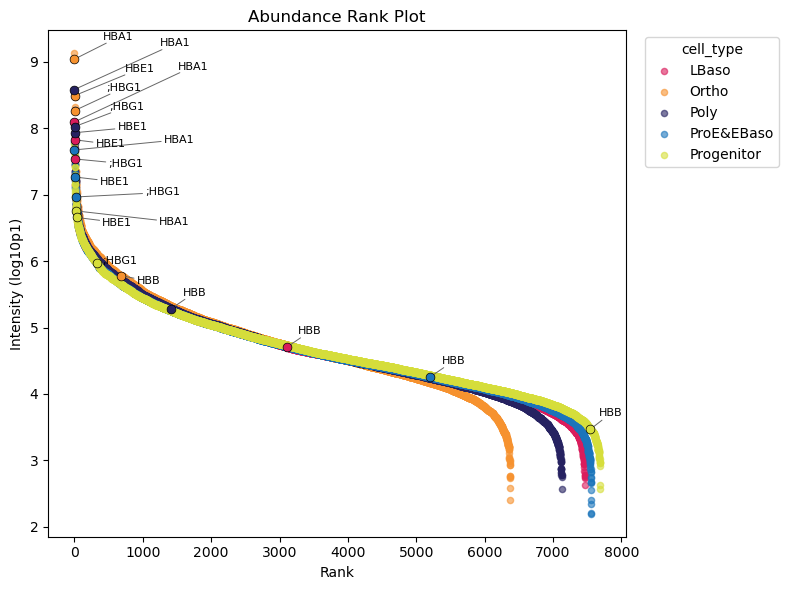

In [10]:
# Haemoglobin proteins are highlighted
pr.pl.abundance_rank(
    adata,
    color='cell_type',
    log_transform=10,
    zero_to_na=True,            # Treat zeros as missing values
    color_scheme=adata.uns["colors_cell_type"],
    summary_method='median',
    highlight_vars=list(haemoglobin.keys()),
    var_labels_key='gene_name', # Use gene names instead of protein IDs for labels
    )

📊 Higher abundance of haemoglobin proteins in the protein distribution is expected and they are expected to increase during erythropoiesis. The abundance rank plot confirms this with exception of HBB proteins.

### Binary Detection Heatmap

`pr.pl.binary_heatmap()` converts intensities into a binary matrix (present/absent) and visualizes it as a heatmap. This is useful for quickly checking detection patterns across samples and proteins.

Here, we consider proteins with log2 intensity > 0 as present and order samples by differentiation stage.

/opt/homebrew/Caskroom/miniforge/base/envs/proteopy1/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


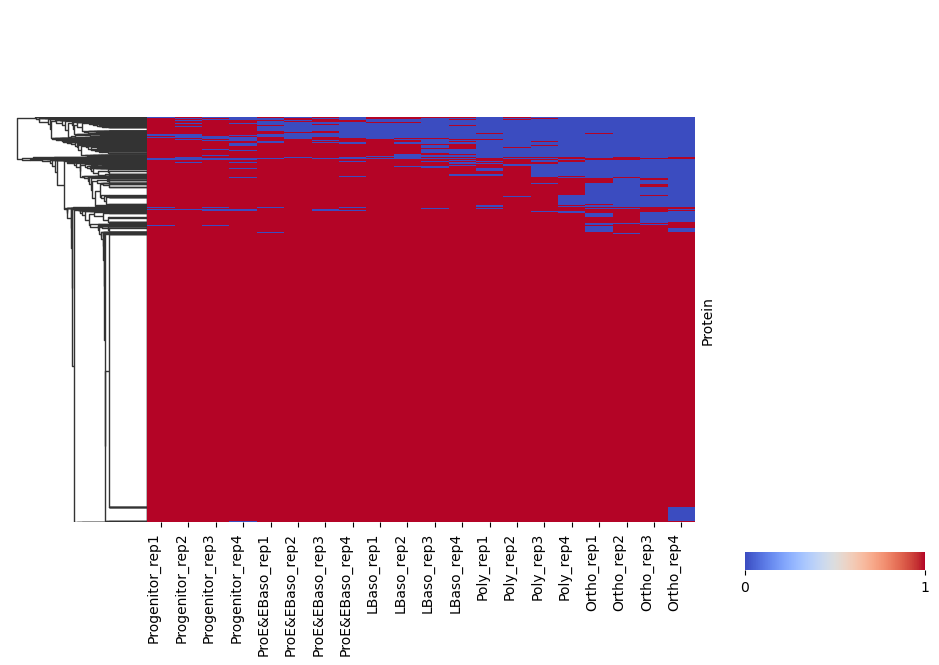

In [11]:
# Binary heatmap: proteins above threshold are encoded as 1 (present), otherwise 0
pr.pl.binary_heatmap(
adata,
threshold=0,
fill_na=0,
order_by='cell_type',
order=adata.uns['diff_order'],
col_cluster=False,
row_cluster=True,
figsize=(10, 6),
)

### Removing Contaminants

Common contaminants (keratins, BSA, trypsin, etc.) should be removed. ProteoPy can download contaminant databases and filter them out:

In [12]:
# Download contaminant FASTA (sources: 'frankenfield2022', 'gpm-crap')
contaminants_path = pr.download.contaminants(source='frankenfield2022')

# Remove proteins matching contaminant sequences
pr.pp.remove_contaminants(
    adata,
    contaminant_path=contaminants_path,
    inplace=True,  # Modify adata directly (default behavior)
    )

Removed 12 contaminating proteins.


/Users/leventetn/Documents/Proteopy/proteopy/proteopy/download/contaminants.py:140: UserWarning: File already exists at data/contaminants_frankenfield2022_2026-02-28.fasta. Use force=True to overwrite.
  warnings.warn(


### Sample Distribution

Check how many samples (replicates) exist per experimental group:

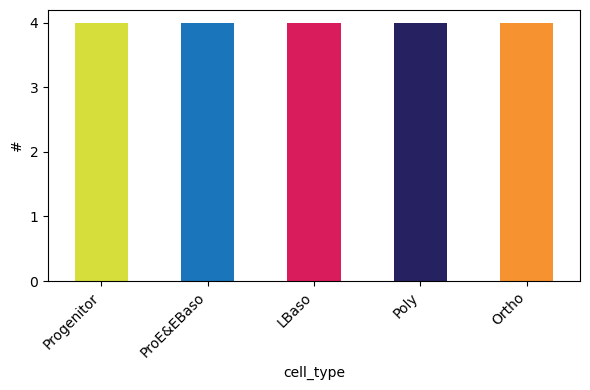

In [13]:
pr.pl.n_samples_per_category(
        adata, 
        category_key='cell_type',
        color_scheme=adata.uns['colors_cell_type'],
        order=adata.uns['diff_order'],
        )

### Filtering Functions

ProteoPy provides filtering at both sample (obs) and protein/peptide (var) levels:

**Variable-level filtering (`pr.pp.filter_var*`):**
- `filter_var()` - General filtering per variable by any criteria
- `filter_var_completeness()` - Filter by fraction/count of non-missing values
- `filter_proteins_by_peptide_count()` - Filter proteins by number of peptides (peptide-level data)

**Sample-level filtering (`pr.pp.filter_samples*`):**
- `filter_samples()` - General filtering per sample by any criteria.
- `filter_samples_completeness()` - Filter by minimum protein count or minimum fraction of non-missing proteins
- `filter_samples_by_category_count()` - Ensure minimum samples per metadata categroy/group

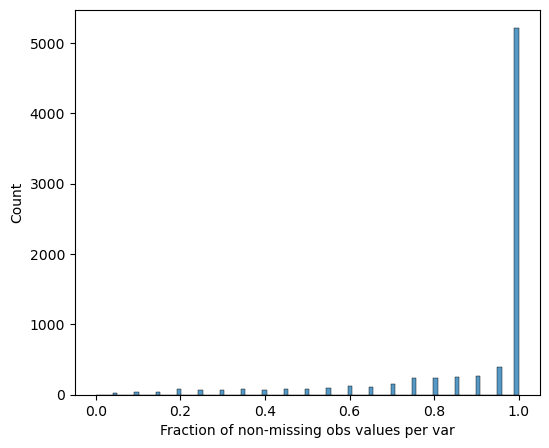

In [14]:
# Visualize protein completeness before filtering
pr.pl.completeness_per_var(adata, zero_to_na=True)

In [15]:
# Require 100% completeness within at least one cell type (group_by='cell_type')
# This keeps proteins that are consistently measured in at least one cell type.
pr.pp.filter_var_completeness(
    adata,
    min_fraction=1,
    group_by='cell_type',
    zero_to_na=True,
    )

277 var removed


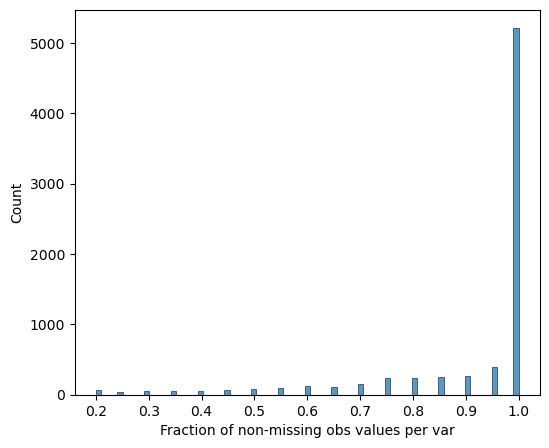

In [16]:
# Verify completeness after filtering
pr.pl.completeness_per_var(adata, zero_to_na=True)

### Sample Quality Assessment

Examine the number of detected proteins per sample. The `order_by` and `order` parameters control how samples are arranged:

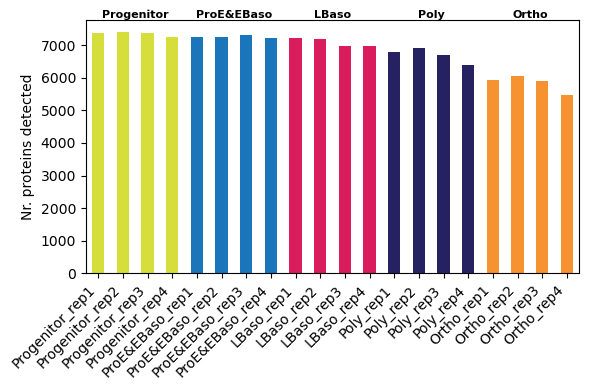

In [17]:
# Per-sample protein counts (individual bars)
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    order_by='cell_type',
    order=adata.uns['diff_order'],
    color_scheme=adata.uns['colors_cell_type'],
    xlabel_rotation=45,
    )

📊 We observe a trend of decreasing detected protein count along differentiation trajectory

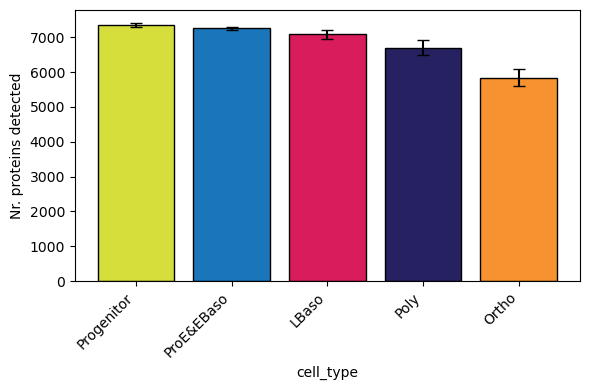

In [18]:
# Grouped by cell type (boxplot per group) - reproduces Figure 1C from Karayel et al.
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='cell_type',  # Aggregate samples into boxplots per group
    order=adata.uns['diff_order'],
    color_scheme=adata.uns['colors_cell_type'],
    xlabel_rotation=45,
    )

In [19]:
# Remove samples with fewer than 6000 detected proteins
pr.pp.filter_samples(adata, min_count=6000)

0 obs removed


### Coefficient of Variation (CV)

The CV measures variability within pre-defined sample groups. When grouping by cell type, variation comes from the replicate samples so the CV represents technical variability. Lower CV indicates better reproducibility:

In [20]:
# Calculate CV per protein within each cell type (stored in adata.var)
pr.pp.calculate_cv(adata, group_by='cell_type', min_samples=3)

Using existing CV data from adata.varm['cv_by_cell_type_X'].


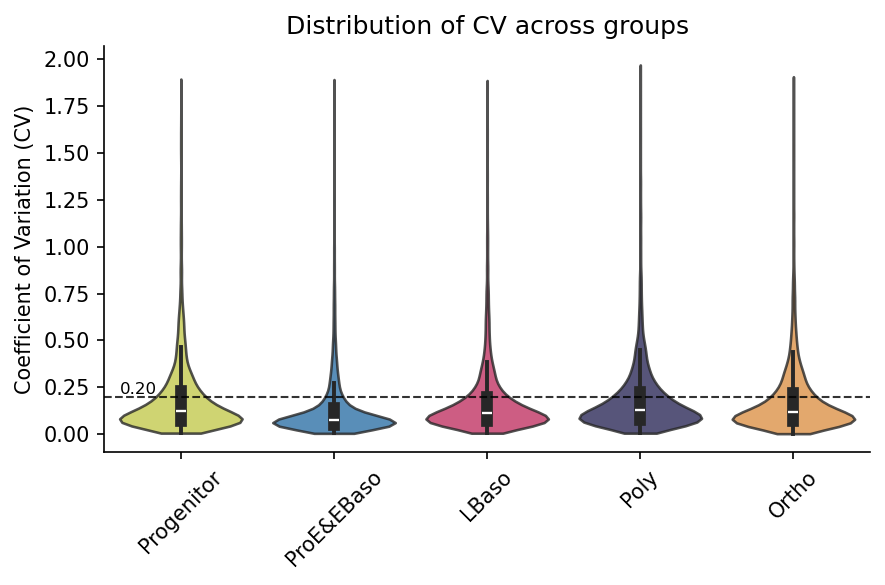

In [21]:
# Visualize CV distribution per group (hline shows typical 20% CV threshold)
pr.pl.cv_by_group(
    adata,
    group_by='cell_type',
    color_scheme=adata.uns["colors_cell_type"],
    figsize=(6, 4),
    xlabel_rotation=45,
    order=adata.uns['diff_order'],
    hline=0.2,  # Reference line at 20% CV
    )

## Data Transformations

Proteomics data typically requires:
1. **Log transformation** - Reduces skewness from normal distribution, stabilizes the mean–variance relationship and makes fold changes symmetric
2. **Normalization** - Corrects for systematic technical variation between samples
3. **Imputation** - Handles missing values for downstream statistical analysis

### Log Transformation

In [22]:
# Convert zeros to NaN (missing values) and log2 transform
# Note: Save raw data in `layers` and then modigy adata.X directly
adata.layers['raw'] = adata.X.copy()
adata.X[adata.X == 0] = np.nan
adata.X = np.log2(adata.X)

### Normalization

Options:
- median normalization

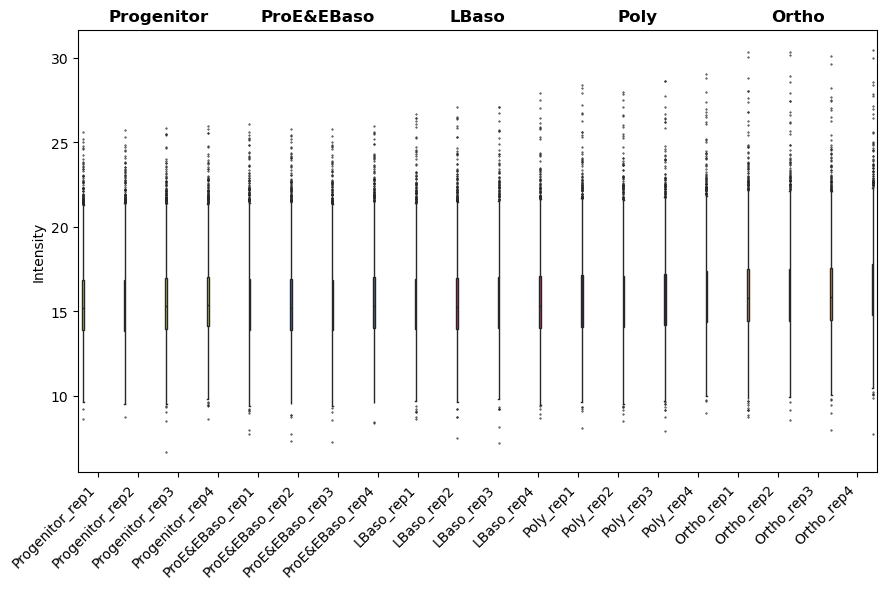

<Axes: ylabel='Intensity'>

In [23]:
# Visualize intensity distributions between samples first
pr.pl.intensity_box_per_sample(
    adata,
    order_by='cell_type',
    order=adata.uns['diff_order'],
    zero_to_na=True,
    color_scheme=adata.uns['colors_cell_type'],
    xlabel_rotation=45,
    figsize=(9, 6),
    )

In [24]:
# Apply median normalization (method='median_ref' uses a reference sample)
pr.pp.normalize_median(
    adata,
    method='median_ref',
    log_space=True, # log_space=True indicates data is already log-transformed
    )

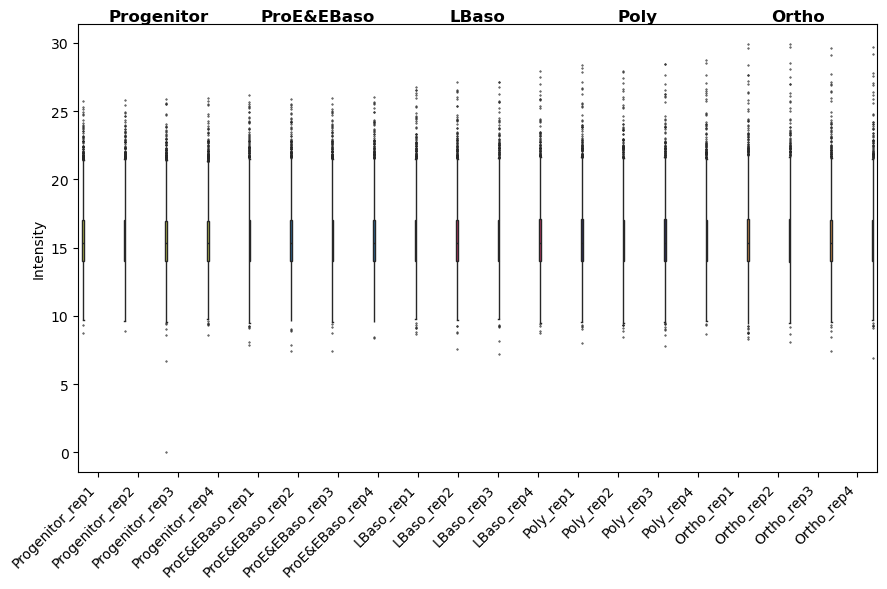

<Axes: ylabel='Intensity'>

In [25]:
# After normalization: distributions should be aligned
pr.pl.intensity_box_per_sample(
    adata,
    order_by='cell_type',
    order=adata.uns['diff_order'],
    zero_to_na=True,
    color_scheme=adata.uns['colors_cell_type'],
    xlabel_rotation=45,
    figsize=(9, 6),
    )

### Imputation

As discussed above, often missing values in proteomics are MNAR — proteins below the detection limit. Down-shift imputation addresses this by sampling replacement values from a distribution shifted below the observed measurements, assuming that missing proteins have low but non-zero abundance:

In [26]:
# Impute missing values using down-shift method
# downshift: How many std devs below mean to center imputed values
# width: Width of the imputation distribution (std devs)
pr.pp.impute_downshift(
    adata,
    downshift=1.8,
    width=0.3,
    zero_to_nan=True,
    random_state=123,  # For reproducibility
    )

In [27]:
# Nr of measured and imputed values
mask = np.asarray(adata.layers["imputation_mask_X"], dtype=bool)
measured_n = int((~mask).sum())
imputed_n = int(mask.sum())
print(f"Measured: {measured_n:,} values ({100*measured_n/(measured_n+imputed_n):.1f}%)")
print(f"Imputed: {imputed_n:,} values ({100*imputed_n/(measured_n+imputed_n):.1f}%)")

Measured: 136,962 values (91.7%)
Imputed: 12,418 values (8.3%)


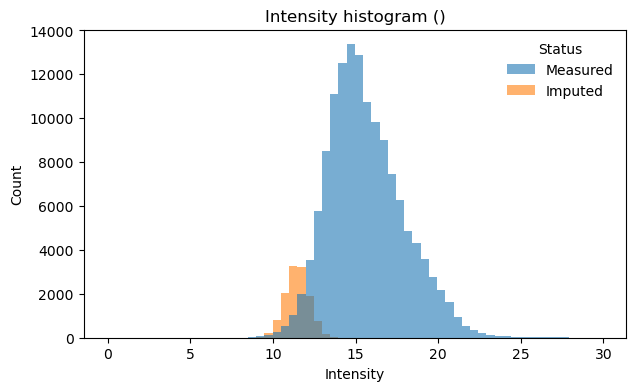

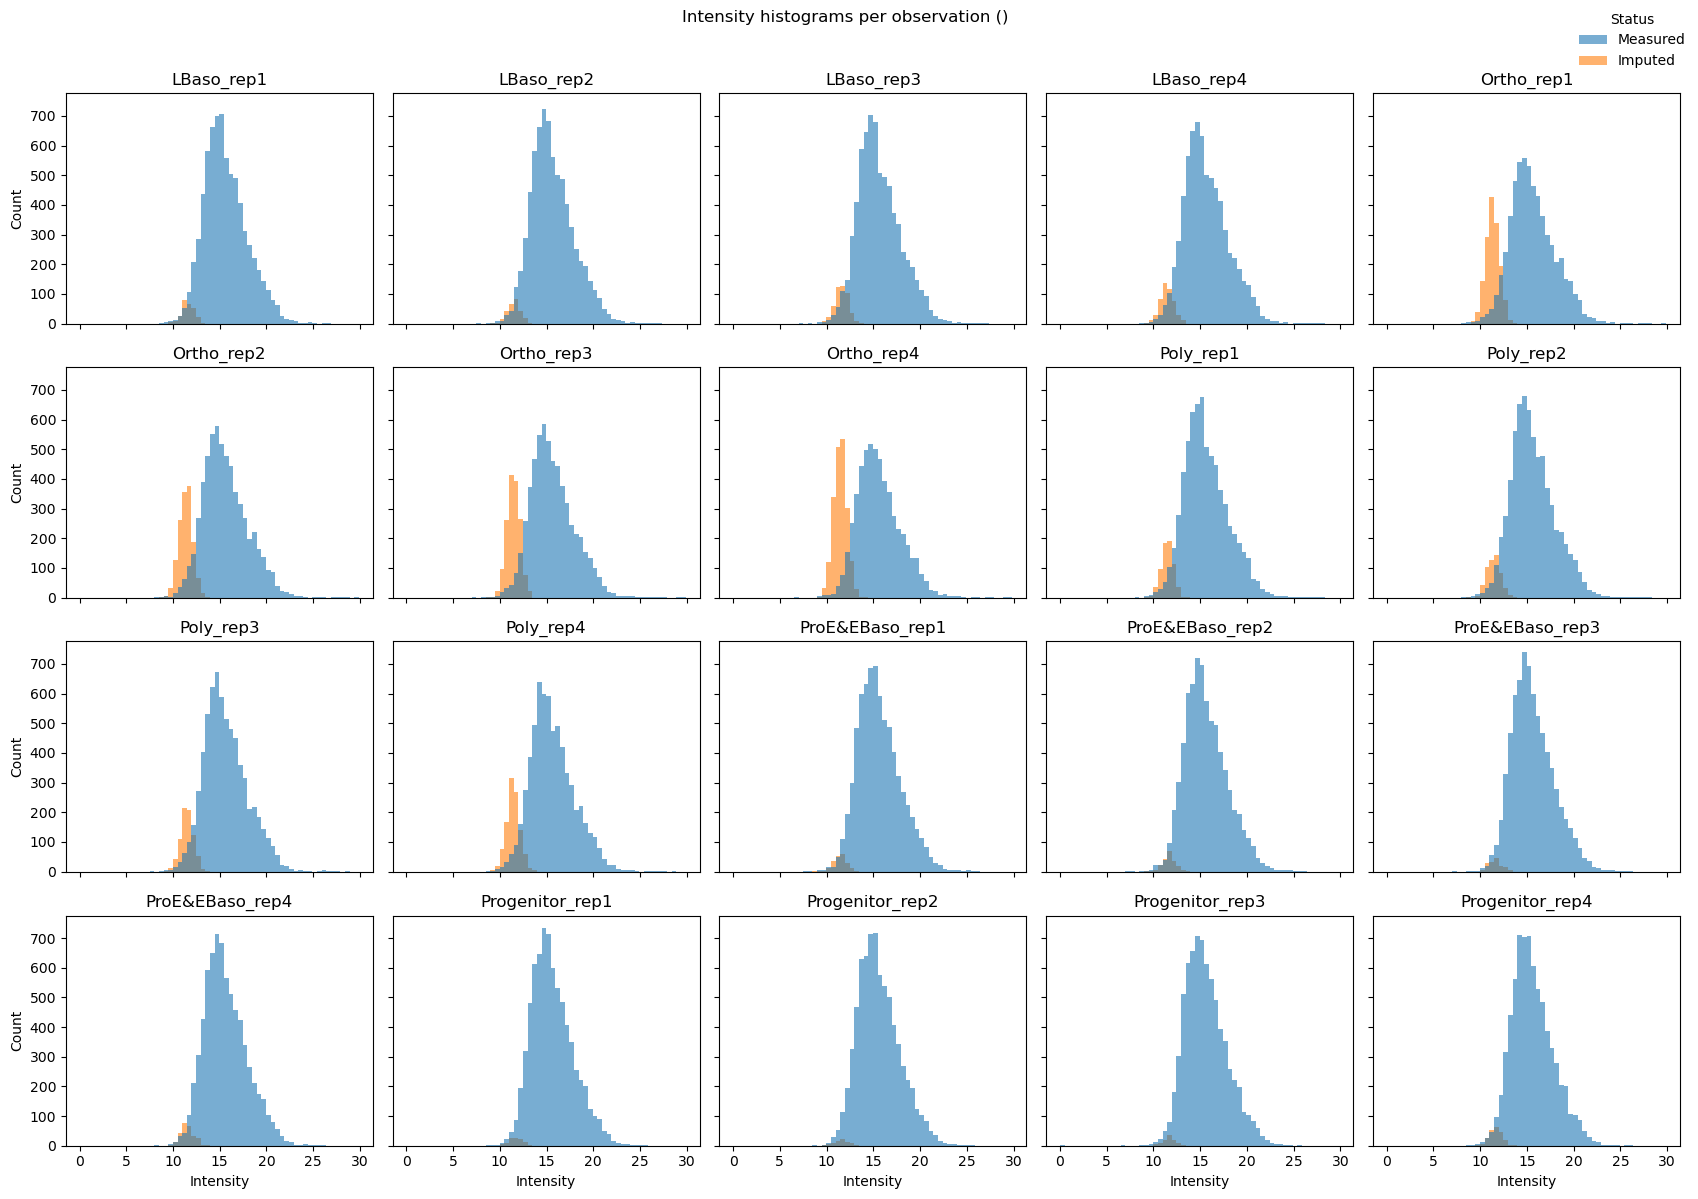

In [28]:
# Visualize intensity distribution with imputed values highlighted

# Combined histogram across all samples
pr.pl.intensity_hist(
    adata,
    color_imputed=True,  # Color imputed vs measured values differently
    density=False,
    )

# Per-sample histograms (small multiples)
pr.pl.intensity_hist(
    adata,
    color_imputed=True,
    per_obs=True,   # One subplot per sample
    ncols=5,
    legend_loc="upper right",
    density=False,
    figsize=(17, 12),
    )

## Dimensionality Reduction and Sample Clustering

ProteoPy integrates with scanpy for dimensionality reduction. PCA and UMAP reveal sample relationships and confirm expected biological groupings.

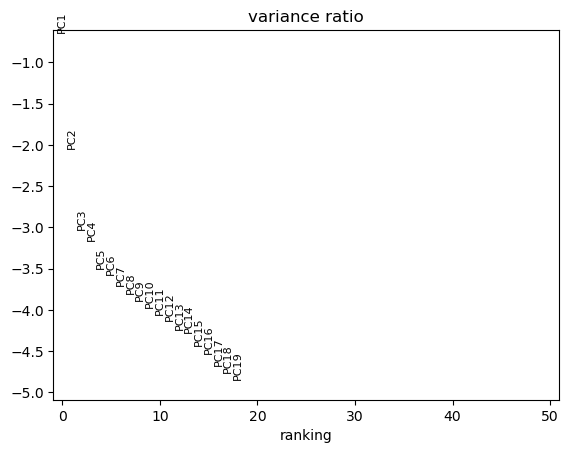

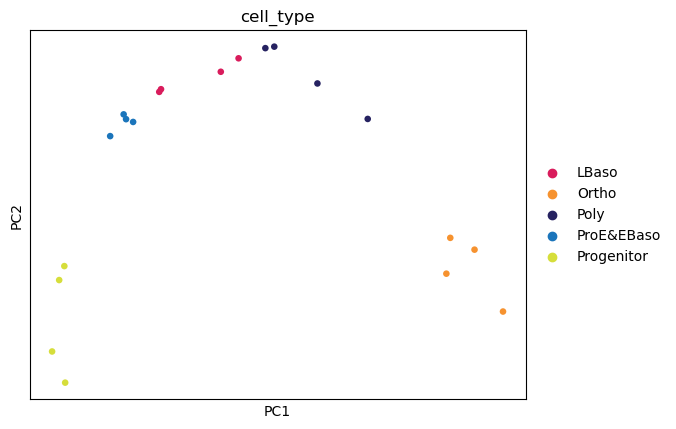

In [29]:
# PCA using scanpy (ProteoPy AnnData is fully compatible)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color='cell_type',
    dimensions=(0, 1),
    ncols=2,
    size=90,
    palette=adata.uns['colors_cell_type'],
    )

📊 The first two principal components resolve the differentiation trajectory indicating that the highest source of variation is the biological process of erythropoiesis.

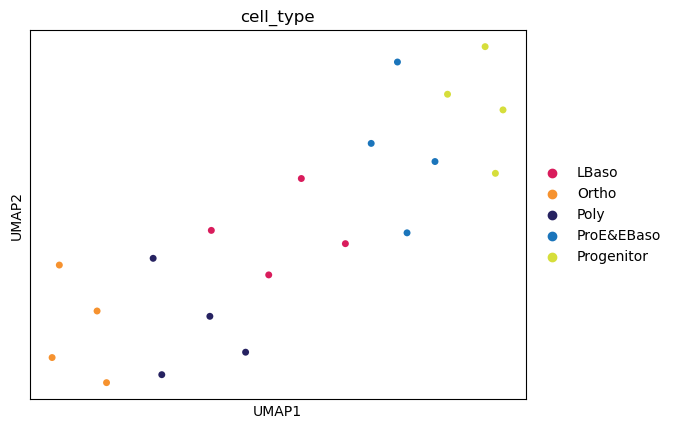

In [30]:
# UMAP for non-linear dimensionality reduction
sc.pp.neighbors(adata, n_neighbors=6)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color='cell_type',
    size=100,
    palette=adata.uns['colors_cell_type'],
    )

📊 Dimensionality reduction identifies cell type clusters.

### Sample Correlation Matrix

A hierarchically clustered correlation matrix shows sample similarity:

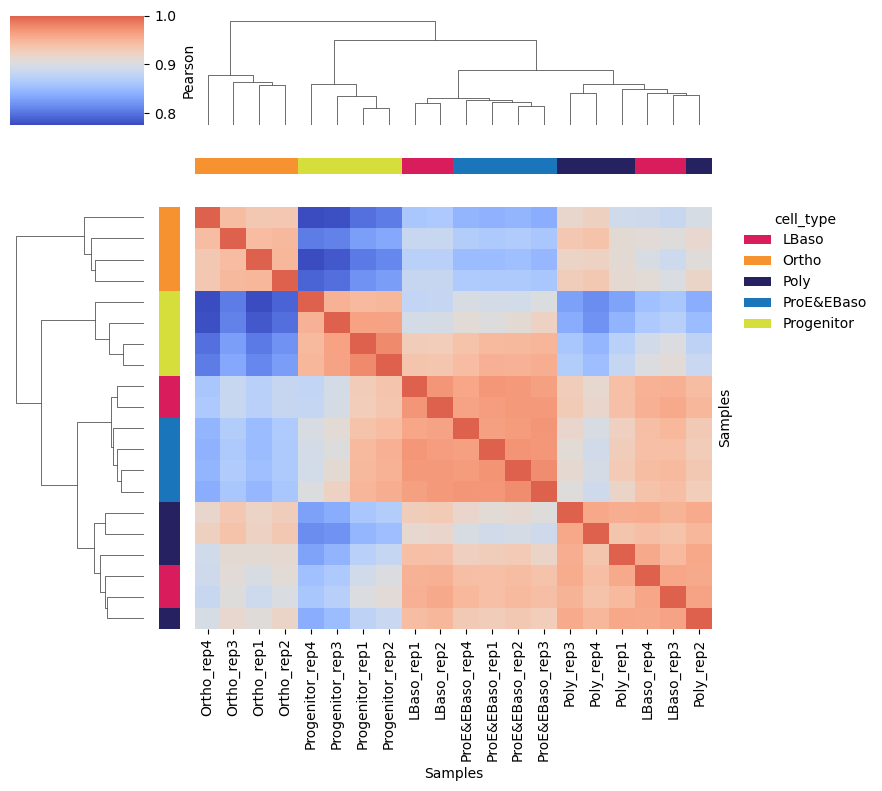

In [31]:
# Clustered sample correlation heatmap with cell type annotation on margins
pr.pl.sample_correlation_matrix(
    adata,
    method="pearson",
    margin_color="cell_type",  # Color bar annotation
    color_scheme=adata.uns["colors_cell_type"],
    xticklabels=True,
    figsize=(9, 8),
    linkage_method='average',
    )

## Highly Variable Proteins

Identifying highly variable proteins (HVPs) highlights proteins that vary most across samples - these often drive biological differences between conditions:

In [32]:
# Use scanpy's HVG detection (marks top 250 most variable proteins in adata.var)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=250,
    inplace=True,
    )

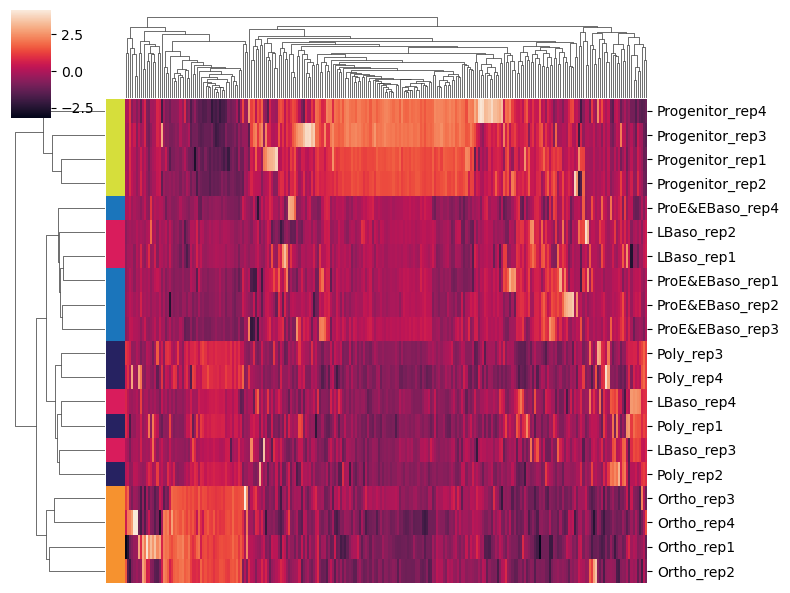

In [33]:
# Subset to highly variable proteins and plot clustered heatmap
adata_hvg = adata[:, adata.var['highly_variable']].copy()

sc.pl.clustermap(
    adata_hvg,
    obs_keys='cell_type',
    z_score=1,          # Z-score normalize per protein (row)
    figsize=(8, 6),
    dendrogram_ratio=0.15,
    show=True,
    xticklabels=False,  # Too many proteins for labels
    )

## Differential Abundance Analysis

ProteoPy performs statistical testing to identify proteins that differ significantly between conditions.

### Running Statistical Tests

Available methods:
- `ttest_two_sample` - Two-sample t-test (assumes equal variance)
- `welch` - Welch's t-test (unequal variance)

Test modes:
- **one_vs_rest**: Compare each group to all others combined (default when `setup={}`)
- **pairwise**: Specify explicit comparisons with `setup={'group1': 'A', 'group2': 'B'}`

In [34]:
# One-vs-rest t-tests for each cell type (results stored in adata.varm)
pr.tl.differential_abundance(
    adata,
    method="ttest_two_sample",
    group_by='cell_type',
    setup={},               # Empty = one-vs-rest for all groups
    multitest_correction='bh',  # Benjamini-Hochberg FDR correction
    alpha=0.05,
    space='log',            # Data is in log space
    )

Saved test results in .varm['ttest_two_sample;cell_type;LBaso_vs_rest']
Saved test results in .varm['ttest_two_sample;cell_type;Ortho_vs_rest']
Saved test results in .varm['ttest_two_sample;cell_type;Progenitor_vs_rest']
Saved test results in .varm['ttest_two_sample;cell_type;ProE_EBaso_vs_rest']
Saved test results in .varm['ttest_two_sample;cell_type;Poly_vs_rest']


### Accessing Test Results

Test results are stored in `adata.varm` slots. Use `pr.get.tests()` to see available results:

In [35]:
# List all stored test results
pr.get.tests(adata)

,key,key_group,test_type,group_by,design,design_label,design_mode,layer
0,ttest_two_sample;cell_type;LBaso_vs_rest,ttest_two_sample;cell_type;one_vs_rest,ttest_two_sample,cell_type,LBaso_vs_rest,LBaso vs rest,one_vs_rest,None
1,ttest_two_sample;cell_type;Ortho_vs_rest,ttest_two_sample;cell_type;one_vs_rest,ttest_two_sample,cell_type,Ortho_vs_rest,Ortho vs rest,one_vs_rest,None
2,ttest_two_sample;cell_type;Progenitor_vs_rest,ttest_two_sample;cell_type;one_vs_rest,ttest_two_sample,cell_type,Progenitor_vs_rest,Progenitor vs rest,one_vs_rest,None
3,ttest_two_sample;cell_type;ProE_EBaso_vs_rest,ttest_two_sample;cell_type;one_vs_rest,ttest_two_sample,cell_type,ProE_EBaso_vs_rest,ProE EBaso vs rest,one_vs_rest,None
4,ttest_two_sample;cell_type;Poly_vs_rest,ttest_two_sample;cell_type;one_vs_rest,ttest_two_sample,cell_type,Poly_vs_rest,Poly vs rest,one_vs_rest,None


Use `pr.get.differential_abundance_df()` to retrieve results as a DataFrame with filtering:

In [36]:
# Get significant proteins across all one-vs-rest tests (|logFC| >= 1, p_adj < 0.05)
pr.get.differential_abundance_df(
    adata,
    key_group='ttest_two_sample;cell_type;one_vs_rest',  # All one-vs-rest tests
    min_logfc=1,        # Minimum absolute log2 fold change
    max_pval=0.05,      # Maximum adjusted p-value
    sort_by='pval_adj', # Sort by adjusted p-value
    )

,var_id,test_type,group_by,design,mean1,mean2,logfc,tstat,pval,pval_adj,is_diff_abundant
0,Q8IXW5;Q8IXW5-2,ttest_two_sample,cell_type,Ortho_vs_rest,21.060375,12.935327,8.125048,23.517326,5.778442e-15,3.114776e-11,True
1,E7ESC6,ttest_two_sample,cell_type,Ortho_vs_rest,19.692222,16.984114,2.708108,16.811764,1.885384e-12,7.040966e-10,True
2,Q8TB52,ttest_two_sample,cell_type,Ortho_vs_rest,16.234364,13.902348,2.332016,15.007092,1.278869e-11,2.449197e-09,True
3,Q7Z333;Q7Z333-4,ttest_two_sample,cell_type,Ortho_vs_rest,16.963578,15.899757,1.063821,14.861999,1.504470e-11,2.613229e-09,True
4,O43516;O43516-2;O43516-3;O43516-4,ttest_two_sample,cell_type,Progenitor_vs_rest,15.411008,11.522910,3.888098,16.436716,2.763870e-12,1.104769e-08,True
...,...,...,...,...,...,...,...,...,...,...,...
956,Q6UW63,ttest_two_sample,cell_type,Progenitor_vs_rest,15.015388,13.067117,1.948270,2.778024,1.240691e-02,4.915014e-02,True
957,Q9UPY3,ttest_two_sample,cell_type,Progenitor_vs_rest,13.912874,12.656495,1.256379,2.777509,1.242059e-02,4.916237e-02,True
958,J9JIC5;Q9HAS0,ttest_two_sample,cell_type,Progenitor_vs_rest,13.641169,12.517267,1.123901,2.774577,1.249870e-02,4.931474e-02,True
959,H0YH69;Q9HBU6,ttest_two_sample,cell_type,Progenitor_vs_rest,13.984629,12.503137,1.481492,2.771020,1.259412e-02,4.953421e-02,True


### Visualization

#### Volcano Plot

Volcano plots show the relationship between fold change (x) and statistical significance (y):

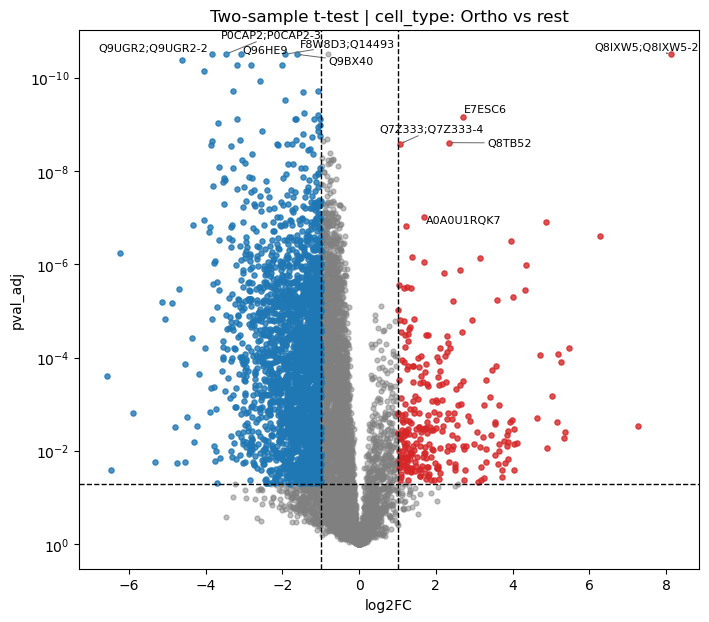

In [37]:
# Volcano plot for Ortho vs rest comparison
pr.pl.volcano_plot(
    adata,
    varm_slot='ttest_two_sample;cell_type;Ortho_vs_rest',
    fc_thresh=1,        # Fold change threshold lines
    pval_thresh=0.05,   # P-value threshold line
    xlabel='log2FC',
    ylabel_logscale=True,
    top_labels=5,       # Label top 5 most significant
    figsize=(8, 7),
    )

#### Box Plots of Top Differentially Abundant Proteins

Examine individual protein intensity distributions:

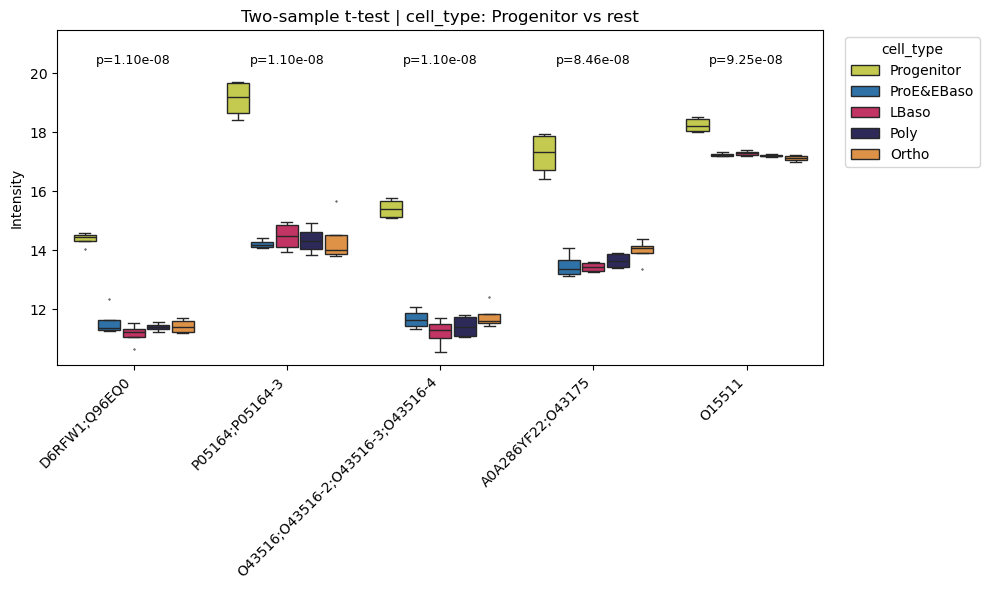

In [38]:
# Box plots for top 5 differentially abundant proteins (Progenitor vs rest)
pr.pl.differential_abundance_box(
    adata,
    varm_slot='ttest_two_sample;cell_type;Progenitor_vs_rest',
    top_n=5,
    color_scheme=adata.uns['colors_cell_type'],
    order=adata.uns['diff_order'],
    )

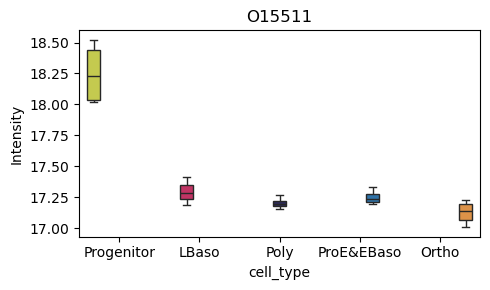

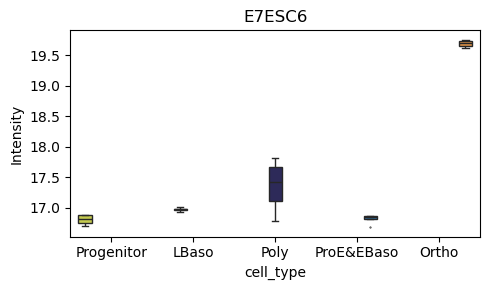

In [39]:
# Box plot for a specific protein of interest
pr.pl.box(
    adata,
    keys=['O15511', 'E7ESC6'],
    group_by='cell_type',
    order=['Progenitor', 'LBaso', 'Poly', 'ProE&EBaso', 'Ortho'],
    color_scheme=adata.uns['colors_cell_type'],
    figsize=(5,3),
    )

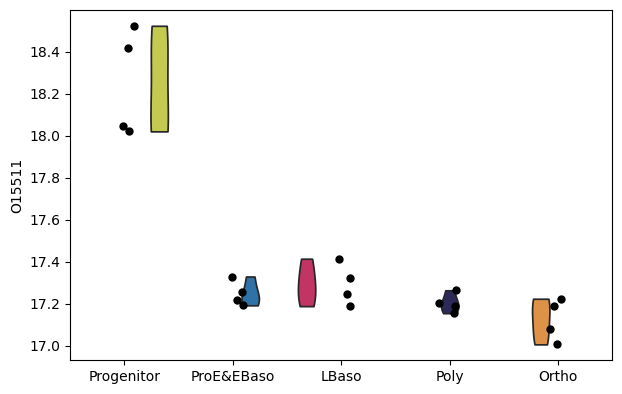

In [40]:
# Alternative: use scanpy's violin plot
sc.pl.violin(
    adata,
    keys=['O15511'],
    groupby='cell_type',
    order=adata.uns['diff_order'],
    size=6,
    xlabel=None,
    )

## Hierarchical Clustering of Proteins

ProteoPy provides tools for clustering proteins by their expression profiles across conditions. This is useful for identifying co-regulated protein groups.

### Profile Heatmap

First, visualize the expression profiles of differentially abundant proteins:

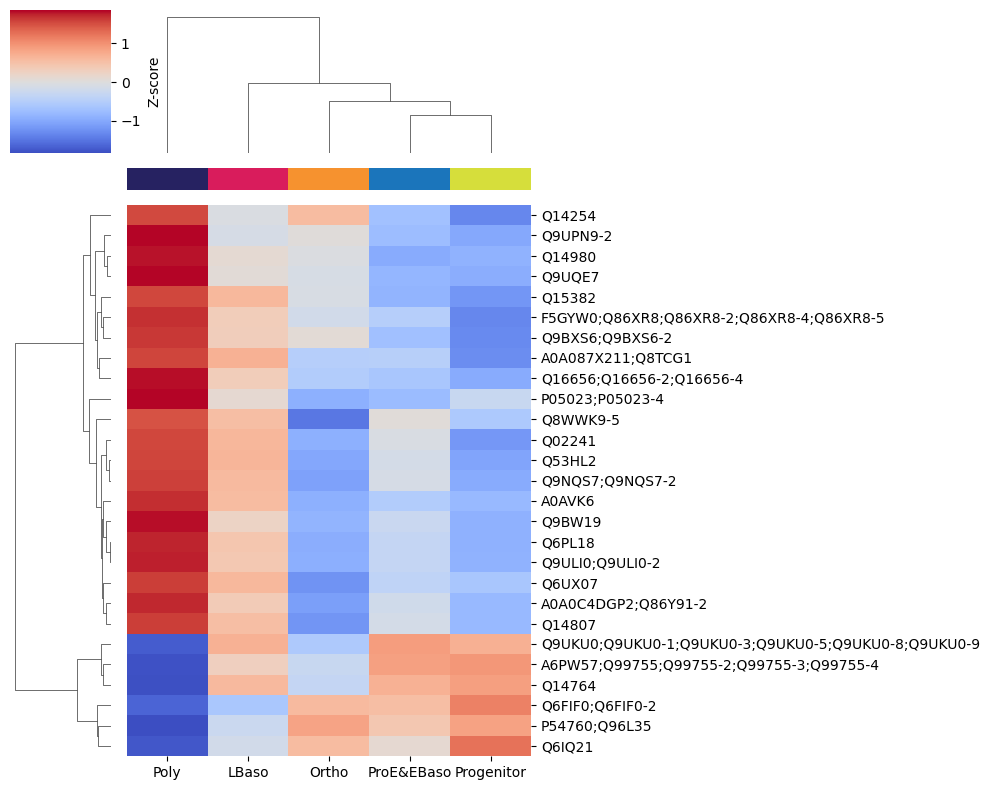

In [41]:
# Get differentially abundant proteins for Poly vs rest
df = pr.get.differential_abundance_df(
    adata,
    keys='ttest_two_sample;cell_type;Poly_vs_rest',
    )
diff_prots = df[df['pval_adj'] <= 0.05]

# Heatmap of mean intensities per cell type for these proteins
pr.pl.hclustv_profiles_heatmap(
    adata,
    group_by='cell_type',
    selected_vars=diff_prots['var_id'],
    yticklabels=True,
    margin_color=True,
    color_scheme=adata.uns['colors_cell_type'],
    )

### Building the Hierarchical Clustering Tree

`pr.tl.hclustv_tree()` builds a hierarchical clustering dendrogram based on mean expression profiles:

In [42]:
# Build hierarchical clustering tree (stored in adata.uns)
pr.tl.hclustv_tree(
    adata,
    group_by='cell_type',
    selected_vars=diff_prots['var_id'],
    verbose=False,
    )

### Determining Optimal Cluster Number

Use silhouette scores and elbow plots to determine the optimal number of clusters (k):

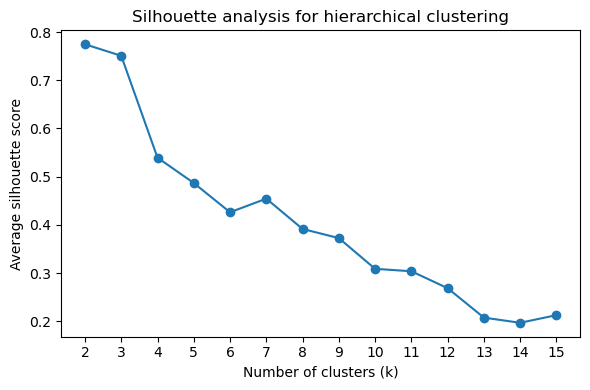

In [43]:
# Silhouette score plot (higher = better cluster separation)
pr.pl.hclustv_silhouette(adata, verbose=False)

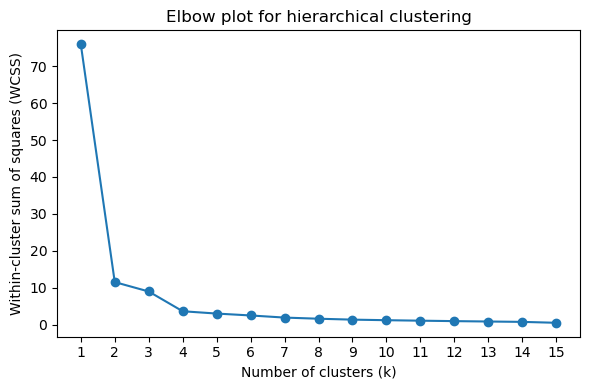

In [44]:
# Elbow plot (look for the "elbow" where inertia decrease slows)
pr.pl.hclustv_elbow(adata, verbose=False)

### Cluster Assignment and Profile Visualization

Cut the dendrogram at k clusters and compute mean profiles per cluster:

In [45]:
# Assign proteins to k=3 clusters and compute cluster profiles
pr.tl.hclustv_cluster_ann(adata, k=3, verbose=False)
pr.tl.hclustv_profiles(adata, verbose=False)

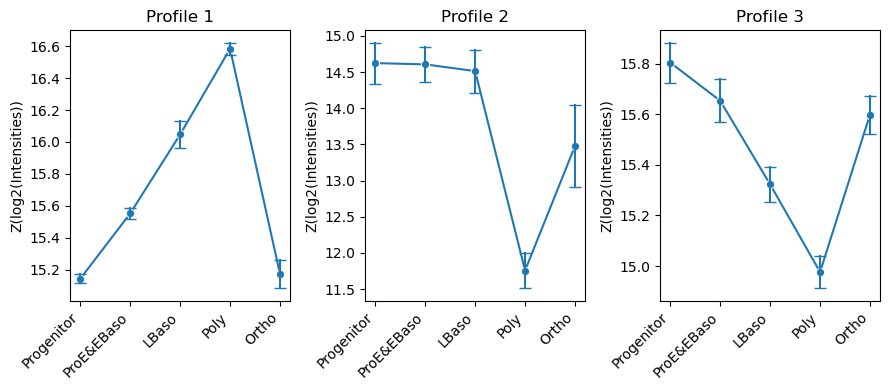

In [46]:
# Visualize cluster profiles: mean ± std intensity across cell types for each cluster
pr.pl.hclustv_profile_intensities(
    adata,
    group_by='cell_type',
    order=adata.uns['diff_order'],
    ylabel='Z(log2(Intensities))',
    verbose=False,
    n_cols=3,
    figsize=(9, 4),
    )

## Summary

This tutorial covered the core ProteoPy workflow for protein-level analysis:

1. **Data loading** - `pr.read.long()` for generic formats, `pr.read.diann()` for DIA-NN output
2. **Annotation** - `pr.ann.obs()` and `pr.ann.var()` for adding metadata
3. **Quality control** - `pr.pp.filter_*()` for filtering, `pr.pl.*` for visualization
4. **Transformation** - Log transformation, `pr.pp.normalize_median()`, `pr.pp.impute_downshift()`
5. **Statistical analysis** - `pr.tl.differential_abundance()` with `pr.get.differential_abundance_df()`
6. **Clustering** - `pr.tl.hclustv_*()` for hierarchical clustering of expression profiles

ProteoPy integrates seamlessly with scanpy for dimensionality reduction (PCA, UMAP) and other single-cell analysis tools.

For more information, see the [ProteoPy documentation](https://proteopy.readthedocs.io/).